<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/transfer_learning_models_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code"

 ACGAN.ipynb		    model_backup
 BAGAN.ipynb		    model_result
 build_datasets.ipynb	    models
 build_datasets_v2.ipynb    new_sars_cov
 build_datasets_v3.ipynb    plots
 COVID-CT-master	    revised-git
'data (can be discarded)'   revised-kaggle
 data-kaggle-uploaded	    revised-kaggle-validation
 ECN_git.ipynb		    train_from_sarscov2.ipynb
 ECN_kaggle.ipynb	    training-from-scratch-git.ipynb
 EN_git.ipynb		   'transfer learning models (backup trash)'
 EN_kaggle.ipynb	    transfer_learning_models_git.ipynb
 Inception_github.ipynb     transfer_learning_models_kaggle.ipynb
 master.ipynb		    trial.ipynb
/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code


In [ ]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = 'revised-kaggle-validation'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
print(dataset_sizes)

{'train': 3021, 'val': 365, 'test': 785}


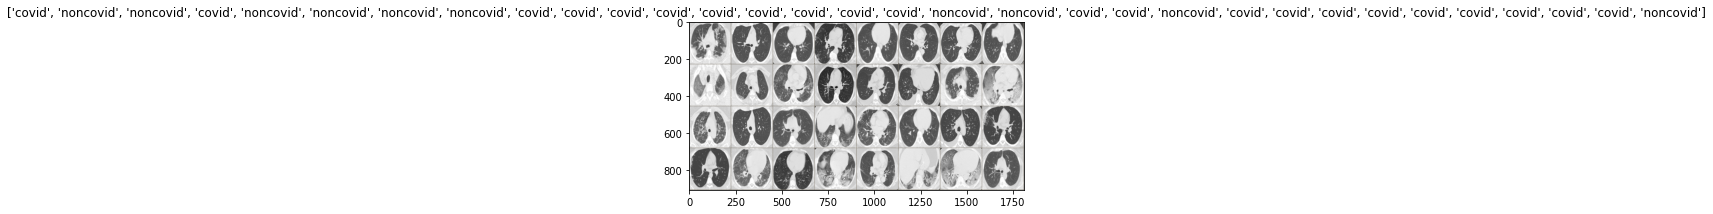

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    "Training begins..."


    train_losses = []
    test_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds, name, num_epochs):
  label = ['noncovid', 'covid']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  report = classification_report(labels, preds, output_dict = True)
  df = pd.DataFrame(report).transpose()
  df.to_csv('model_result/'+name+'_epochs_'+str(num_epochs)+'_classification_report.csv', index = False)


  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['NonCovid', 'Covid'],
                      title='Confusion matrix')
  plt.savefig('plots/CM '+name+'_epochs_'+str(num_epochs)+'.png')
  plt.show()

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

In [ ]:
# Do validation on the test set (from another dataset)
def test_on_another_data(model, test_data, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in test_data:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

<h1>Models</h1>

In [ ]:
from collections import OrderedDict


# classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,2)),
#     #('out', nn.LogSoftmax(dim=1)),
# ]))

In [ ]:
train_losses_all = []
test_losses_all = []

In [ ]:
def run_model(model, name, freeze = False):
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = freeze

  #model.classifier = classifier


  if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    
  # NLLLoss because our output is LogSoftmax
  #criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  num_epochs = 50

  model_ft, train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=num_epochs)
  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)

  test(model, dataloaders, device, name, num_epochs)

  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=False)

  plt.savefig("plots/"+name+"_epoch_"+str(num_epochs)+"_losses.png")
  torch.save(model, "model_backup/"+name+"_epoch_"+str(num_epochs)+".pth")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.4552 Acc: 0.7723
val Loss: 0.3356 Acc: 0.8822

Epoch 2/50
----------
train Loss: 0.2360 Acc: 0.9030
val Loss: 0.2195 Acc: 0.9014

Epoch 3/50
----------
train Loss: 0.1821 Acc: 0.9318
val Loss: 0.1862 Acc: 0.9205

Epoch 4/50
----------
train Loss: 0.0984 Acc: 0.9629
val Loss: 0.2382 Acc: 0.9233

Epoch 5/50
----------
train Loss: 0.0792 Acc: 0.9715
val Loss: 0.3773 Acc: 0.8877

Epoch 6/50
----------
train Loss: 0.0871 Acc: 0.9695
val Loss: 0.1569 Acc: 0.9205

Epoch 7/50
----------
train Loss: 0.0373 Acc: 0.9864
val Loss: 0.2394 Acc: 0.9041

Epoch 8/50
----------
train Loss: 0.0701 Acc: 0.9762
val Loss: 0.2380 Acc: 0.9425

Epoch 9/50
----------
train Loss: 0.0241 Acc: 0.9930
val Loss: 0.3943 Acc: 0.9342

Epoch 10/50
----------
train Loss: 0.0348 Acc: 0.9897
val Loss: 0.4420 Acc: 0.9014

Epoch 11/50
----------
train Loss: 0.0443 Acc: 0.9861
val Loss: 0.2281 Acc: 0.9370

Epoch 12/50
----------
train Loss: 0.0312 Acc: 0.9904
val Loss: 0.32

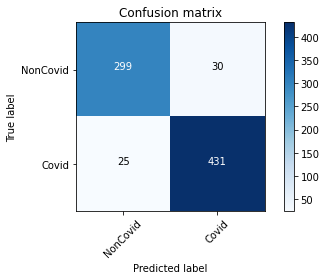

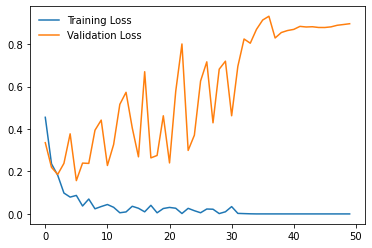

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
run_model(model, name = "vgg16",  freeze = True)

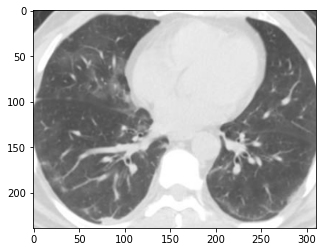

In [ ]:
import cv2

img = cv2.imread("revised-kaggle-validation/train/covid/11.png")
plt.imshow(img)
plt.show()

train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3565 Acc: 0.9425

Epoch 43/50
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3845 Acc: 0.9397

Epoch 44/50
----------
train Loss: 0.0409 Acc: 0.9864
val Loss: 0.6751 Acc: 0.8575

Epoch 45/50
----------
train Loss: 0.0417 Acc: 0.9851
val Loss: 0.7643 Acc: 0.8493

Epoch 46/50
----------
train Loss: 0.0306 Acc: 0.9897
val Loss: 0.3240 Acc: 0.8959

Epoch 47/50
----------
train Loss: 0.0364 Acc: 0.9871
val Loss: 0.3407 Acc: 0.9233

Epoch 48/50
----------
train Loss: 0.0119 Acc: 0.9960
val Loss: 0.3177 Acc: 0.9260

Epoch 49/50
----------
train Loss: 0.0064 Acc: 0.9980
val Loss: 0.3448 Acc: 0.9288

Epoch 50/50
----------
train Loss: 0.0030 Acc: 0.9990
val Loss: 0.2284 Acc: 0.9178

Training complete in 47m 31s
Best valid accuracy: 0.956164
Testing Accuracy: 0.040
Testing Accuracy: 0.078
Testing Accuracy: 0.114
Testing Accuracy: 0.154
Testing Accuracy: 0.192
Testing Accuracy: 0.231
Testing Accuracy: 0.270
Testing Accuracy: 0.309
Testing Accuracy

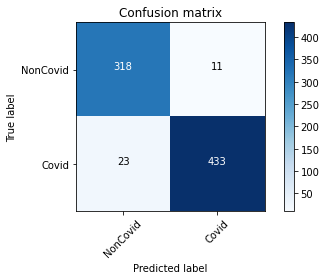

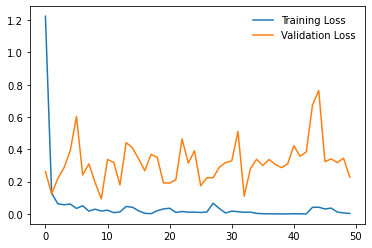

In [ ]:
model = models.resnet101(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = "resnet101",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth




Using GPU: True
Epoch 1/50
----------
Using GPU: True
Epoch 1/50
----------
train Loss: 1.2030 Acc: 0.8070
train Loss: 1.2030 Acc: 0.8070
val Loss: 0.2466 Acc: 0.9342

Epoch 2/50
----------
val Loss: 0.2466 Acc: 0.9342

Epoch 2/50
----------
train Loss: 0.1016 Acc: 0.9682
train Loss: 0.1016 Acc: 0.9682
val Loss: 0.3699 Acc: 0.8904

Epoch 3/50
----------
val Loss: 0.3699 Acc: 0.8904

Epoch 3/50
----------
train Loss: 0.0634 Acc: 0.9755
train Loss: 0.0634 Acc: 0.9755
val Loss: 0.3402 Acc: 0.9178

Epoch 4/50
----------
val Loss: 0.3402 Acc: 0.9178

Epoch 4/50
----------
train Loss: 0.0582 Acc: 0.9791
train Loss: 0.0582 Acc: 0.9791
val Loss: 0.2971 Acc: 0.9096

Epoch 5/50
----------
val Loss: 0.2971 Acc: 0.9096

Epoch 5/50
----------
train Loss: 0.0325 Acc: 0.9884
train Loss: 0.0325 Acc: 0.9884
val Loss: 0.2638 Acc: 0.9315

Epoch 6/50
----------
val Loss: 0.2638 Acc: 0.9315

Epoch 6/50
----------
train Loss: 0.0181 Acc: 0.9950
train Loss: 0.0181 Acc: 0.9950
val Loss: 0.4768 Acc: 0.8658



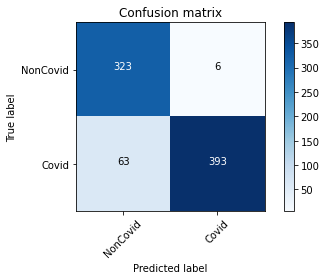

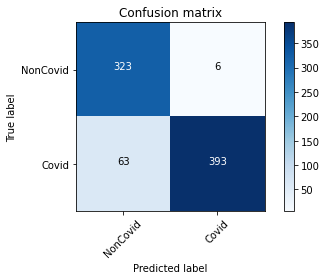

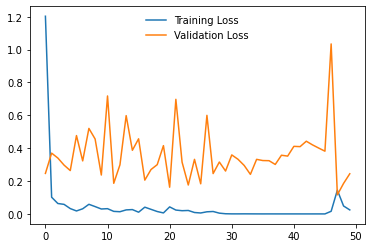

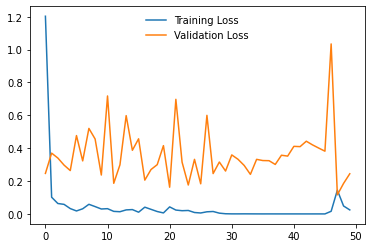

In [ ]:
model = models.resnet152(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = "resnet152",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.3488 Acc: 0.7954
val Loss: 0.2261 Acc: 0.8932

Epoch 2/50
----------
train Loss: 0.1212 Acc: 0.9550
val Loss: 0.3788 Acc: 0.8822

Epoch 3/50
----------
train Loss: 0.0732 Acc: 0.9742
val Loss: 0.2726 Acc: 0.9205

Epoch 4/50
----------
train Loss: 0.0739 Acc: 0.9752
val Loss: 0.4296 Acc: 0.9397

Epoch 5/50
----------
train Loss: 0.0466 Acc: 0.9841
val Loss: 0.4606 Acc: 0.9233

Epoch 6/50
----------
train Loss: 0.0384 Acc: 0.9868
val Loss: 0.5441 Acc: 0.8959

Epoch 7/50
----------
train Loss: 0.0215 Acc: 0.9940
val Loss: 0.6590 Acc: 0.8932

Epoch 8/50
----------
train Loss: 0.0125 Acc: 0.9967
val Loss: 0.4732 Acc: 0.9178

Epoch 9/50
----------
train Loss: 0.0098 Acc: 0.9960
val Loss: 0.7756 Acc: 0.8822

Epoch 10/50
----------
train Loss: 0.0229 Acc: 0.9917
val Loss: 0.3487 Acc: 0.9041

Epoch 11/50
----------
train Loss: 0.0205 Acc: 0.9911
val Loss: 0.2978 Acc: 0.9260

Epoch 12/50
----------
train Loss: 0.0277 Acc: 0.9911
val Loss: 0.57

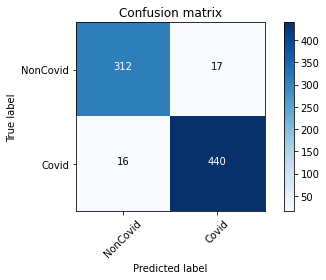

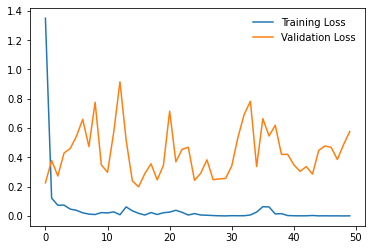

In [ ]:
model = models.resnet50(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "resnet50", freeze = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 2.0908 Acc: 0.7332
val Loss: 0.4371 Acc: 0.8822

Epoch 2/50
----------
train Loss: 0.1761 Acc: 0.9537
val Loss: 0.3413 Acc: 0.9205

Epoch 3/50
----------
train Loss: 0.0876 Acc: 0.9742
val Loss: 0.3787 Acc: 0.9315

Epoch 4/50
----------
train Loss: 0.0631 Acc: 0.9801
val Loss: 0.4599 Acc: 0.9151

Epoch 5/50
----------
train Loss: 0.0375 Acc: 0.9894
val Loss: 0.3976 Acc: 0.9014

Epoch 6/50
----------
train Loss: 0.0236 Acc: 0.9914
val Loss: 0.5570 Acc: 0.8822

Epoch 7/50
----------
train Loss: 0.0444 Acc: 0.9841
val Loss: 0.5989 Acc: 0.8438

Epoch 8/50
----------
train Loss: 0.0281 Acc: 0.9904
val Loss: 0.6110 Acc: 0.8658

Epoch 9/50
----------
train Loss: 0.0291 Acc: 0.9891
val Loss: 0.4216 Acc: 0.8767

Epoch 10/50
----------
train Loss: 0.0345 Acc: 0.9881
val Loss: 0.5313 Acc: 0.8849

Epoch 11/50
----------
train Loss: 0.0350 Acc: 0.9884
val Loss: 0.3218 Acc: 0.9178

Epoch 12/50
----------
train Loss: 0.0220 Acc: 0.9917
val Loss: 0.35

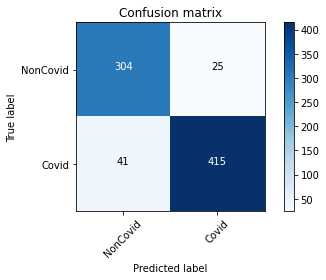

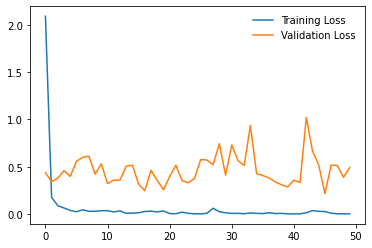

In [ ]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "resnet18", freeze = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.3311 Acc: 0.8491
val Loss: 0.2625 Acc: 0.8904

Epoch 2/50
----------
train Loss: 0.1083 Acc: 0.9626
val Loss: 0.1604 Acc: 0.9370

Epoch 3/50
----------
train Loss: 0.0576 Acc: 0.9828
val Loss: 0.3093 Acc: 0.9288

Epoch 4/50
----------
train Loss: 0.0292 Acc: 0.9907
val Loss: 0.2689 Acc: 0.9370

Epoch 5/50
----------
train Loss: 0.0279 Acc: 0.9917
val Loss: 0.1745 Acc: 0.9425

Epoch 6/50
----------
train Loss: 0.0252 Acc: 0.9917
val Loss: 0.1536 Acc: 0.9534

Epoch 7/50
----------
train Loss: 0.0138 Acc: 0.9947
val Loss: 0.1470 Acc: 0.9452

Epoch 8/50
----------
train Loss: 0.0158 Acc: 0.9950
val Loss: 0.1687 Acc: 0.9425

Epoch 9/50
----------
train Loss: 0.0313 Acc: 0.9884
val Loss: 0.4686 Acc: 0.8986

Epoch 10/50
----------
train Loss: 0.0319 Acc: 0.9904
val Loss: 0.2661 Acc: 0.9260

Epoch 11/50
----------
train Loss: 0.0178 Acc: 0.9947
val Loss: 0.1340 Acc: 0.9534

Epoch 12/50
----------
train Loss: 0.0159 Acc: 0.9947
val Loss: 0.23

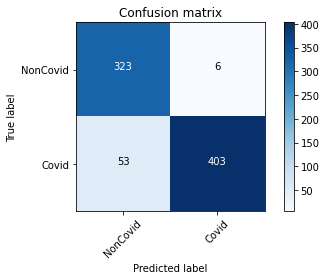

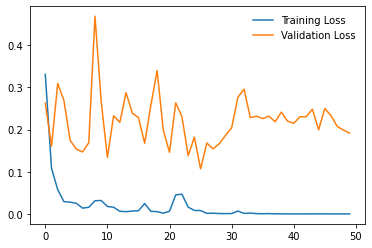

In [ ]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "densenet121", freeze = True)

<h1>Plot All Losses</h1>

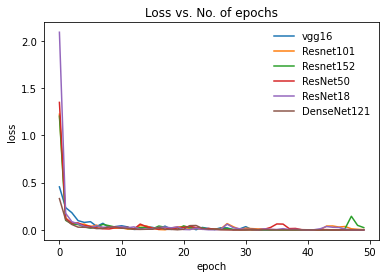

In [ ]:
def plot_all_losses(losses, t):
    plt.figure()
    models = ['vgg16', 'Resnet101','Resnet152', 'ResNet50', 'ResNet18', 'DenseNet121']

    for i, val in enumerate(losses):
        plt.plot(val, label=models[i])
        plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')   
    plt.savefig("plots/"+t+"_losses_resnet.png")
    plt.show()
        
plot_all_losses(train_losses_all, t="training")

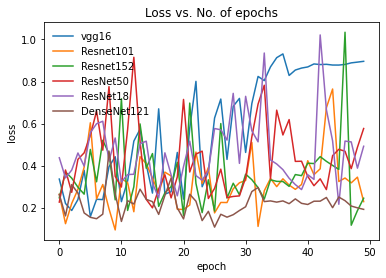

In [ ]:
plot_all_losses(test_losses_all, t="testing")

<h1>Testing trained models on Sars_Cov_2 on CT_COVID dataset test set</h1>

In [ ]:
#densenet121_epoch_50.pth
#resnet18_epoch_50.pth
#resnet50_epoch_50.pth
#resnet101_epoch_50.pth
#resnet152_epoch_50.pth
#vgg16_epoch_50.pth

test_transform = transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

images_covid = "revised-git/"
test_datasets = datasets.ImageFolder(os.path.join(images_covid, 'test'),transform= test_transform)

test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
print(len(test_loader))

7


In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/vgg16_epoch_50.pth")
name = "vgg16_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.026
Testing Accuracy: 0.047
Testing Accuracy: 0.072
Testing Accuracy: 0.101


Testing Accuracy: 0.025
Testing Accuracy: 0.043
Testing Accuracy: 0.068
Testing Accuracy: 0.089
Testing Accuracy: 0.116
Testing Accuracy: 0.139
Testing Accuracy: 0.157
[[56 42]
 [45 60]]
[57.14285714 57.14285714]
Accuracy score: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        98
           1       0.59      0.57      0.58       105

    accuracy                           0.57       203
   macro avg       0.57      0.57      0.57       203
weighted avg       0.57      0.57      0.57       203

Confusion matrix, without normalization
[[56 42]
 [45 60]]


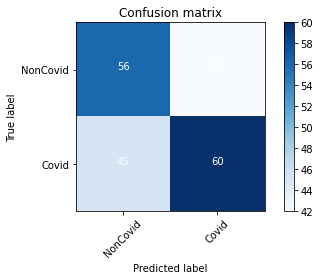

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet152_epoch_50.pth")
name = "resnet152_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.016
Testing Accuracy: 0.032
Testing Accuracy: 0.059
Testing Accuracy: 0.079
Testing Accuracy: 0.100
Testing Accuracy: 0.120
Testing Accuracy: 0.145
[[30 68]
 [32 73]]
[30.6122449  69.52380952]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        98
           1       0.52      0.70      0.59       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.48       203
weighted avg       0.50      0.51      0.49       203

Confusion matrix, without normalization
[[30 68]
 [32 73]]


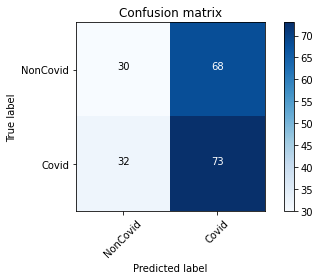

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet101_epoch_50.pth")
name = "resnet101_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.024
Testing Accuracy: 0.043
Testing Accuracy: 0.060
Testing Accuracy: 0.083
Testing Accuracy: 0.106
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[37 61]
 [39 66]]
[37.75510204 62.85714286]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.38      0.43        98
           1       0.52      0.63      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[37 61]
 [39 66]]


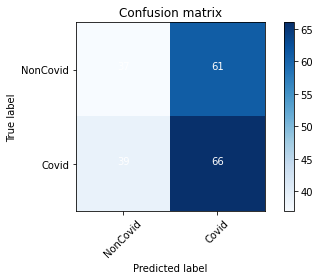

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet50_epoch_50.pth")
name = "resnet50_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.044
Testing Accuracy: 0.061
Testing Accuracy: 0.080
Testing Accuracy: 0.101
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


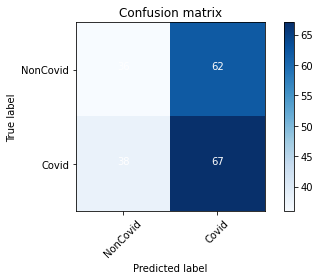

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.040
Testing Accuracy: 0.064
Testing Accuracy: 0.087
Testing Accuracy: 0.105
Testing Accuracy: 0.124
Testing Accuracy: 0.138
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


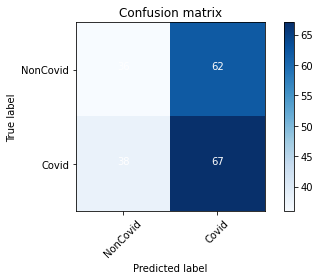

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.038
Testing Accuracy: 0.078
Testing Accuracy: 0.115
Testing Accuracy: 0.150
Testing Accuracy: 0.186
Testing Accuracy: 0.225
Testing Accuracy: 0.262
Testing Accuracy: 0.303
Testing Accuracy: 0.339
Testing Accuracy: 0.376
Testing Accuracy: 0.414
Testing Accuracy: 0.452
Testing Accuracy: 0.491
Testing Accuracy: 0.529
Testing Accuracy: 0.569
Testing Accuracy: 0.604
Testing Accuracy: 0.642
Testing Accuracy: 0.675
Testing Accuracy: 0.711
Testing Accuracy: 0.748
Testing Accuracy: 0.785
Testing Accuracy: 0.820
Testing Accuracy: 0.855
Testing Accuracy: 0.891
Testing Accuracy: 0.922
[[323   6]
 [ 53 403]]
[98.17629179 88.37719298]
Accuracy score: 0.9248407643312102
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       329
           1       0.99      0.88      0.93       456

    accuracy                           0.92       785
   macro avg       0.92      0.93      0.92       785
weighted avg       0.93      0.92      0.93 

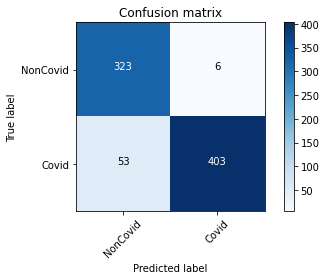

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/densenet121_epoch_50.pth")
name = "densenet121_epoch_50_epoch_50_on_git_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)